# 🧠 Project Overview: AI vs OR for the 0/1 Knapsack Problem

## 🎯 Goal

In this project, we aim to solve the **0/1 Knapsack Problem** using two different approaches:

1. ✅ **Exact Solution** using **Google OR-Tools**, a powerful operations research solver.
2. 🤖 **Approximate Solution** using a **Machine Learning model** trained to predict the optimal value based on problem features.

After implementing both, we will **compare the accuracy and efficiency** (in terms of runtime and quality of solution) between the AI-based approximation and the traditional OR approach.

---

## 🎒 What is the 0/1 Knapsack Problem?

Given a set of `n` items, each with:
- a **weight** `wᵢ`
- a **value** `vᵢ`

...and a **maximum capacity** `C` for the knapsack, the goal is to **select a subset of items** such that:

- The total weight does **not exceed** the capacity `C`
- The total value is **maximized**

Each item can either be included **(1)** or not included **(0)** — hence "0/1".

---

Our goal is to **maximize total value** without exceeding the weight capacity of the knapsack.


## 🛠 Our Approach

We will follow these steps:

1. **Generate synthetic data**: Create many random knapsack instances with different items, weights, values, and capacities.
2. **Solve each instance using OR-Tools**: Get the exact optimal solution (items selected, total value).
3. **Train ML models**: Use supervised learning (regression) to predict the optimal total value from features.
4. **Evaluate and compare**:
   - Accuracy of ML predictions vs OR-Tools output
   - Speed/performance comparison
   - Discuss strengths/weaknesses of both methods

---

## 📌 Final Objective

- Understand how **AI can approximate combinatorial optimization problems**
- Compare it with exact mathematical solvers like OR-Tools
- Demonstrate the trade-off between **accuracy and efficiency**

Let’s get started 🚀


# 📘 References

*   [OR-Tools Documentation](https://developers.google.com/optimization)
*   [scikit-learn Documentation](https://scikit-learn.org/stable/)
*    [Knapsack Problem - Wikipedia](https://en.wikipedia.org/wiki/Knapsack_problem)

In [1]:
!pip install ortools

In [2]:
import numpy as np
import pandas as pd
from ortools.algorithms.python import knapsack_solver
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

## Dataset Generation & Optimal Labeling using OR-Tools

We simulate multiple instances of the 0/1 Knapsack Problem. For each instance, we randomly generate:
- A list of item values.
- A list of item weights.
- A knapsack capacity.

To determine the **optimal selection of items** for each instance, we use the `KnapsackSolver` class from `ortools.algorithms.python`.

The solver returns the best set of items that maximize the total value without exceeding the given capacity. These selections are then used as **supervised labels** for training the machine learning model.


In [3]:
# Set seed for reproducibility
np.random.seed(42)

# Parameters
n_examples = 10000
n_items = 20

# Generate synthetic data
synthetic_data = []
for _ in range(n_examples):
    values = np.random.randint(10, 501, size=n_items).tolist()
    weights = np.random.randint(1, 101, size=n_items).tolist()
    total_weight = sum(weights)
    capacity = int(np.random.uniform(0.4, 0.6) * total_weight)
    synthetic_data.append([values, weights, capacity])

# Create DataFrame and save
df_synthetic = pd.DataFrame(synthetic_data, columns=['values', 'weights', 'capacity'])
df_synthetic.to_csv("knapsack_dataset_10000examples.csv", index=False)

In [4]:
df_synthetic.iloc[0]

,0
values,"[112, 445, 358, 280, 116, 81, 198, 30, 112, 13..."
weights,"[22, 53, 2, 88, 30, 38, 2, 64, 60, 21, 33, 76,..."
capacity,589


### Optimal Label Generation using OR-Tools

For each knapsack instance:
- We initialize the solver with the values, weights, and capacity.
- The solver computes the optimal solution.
- We record a binary label for each item (1 if selected, 0 otherwise).

These labels serve as ground truth for supervised learning.


In [5]:
from ortools.algorithms.python import knapsack_solver

In [6]:
solver = knapsack_solver.KnapsackSolver(
    knapsack_solver.SolverType.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    "KnapsackExample",
)

In [7]:
for i in range(df_synthetic.shape[0]) :
  print(f"exemple {i+1}")
  values = df_synthetic.iloc[i][0]
  weights = [df_synthetic.iloc[i][1]]
  capacities = [df_synthetic.iloc[i][2]]
  solver.init(values, weights, capacities)
  computed_value = solver.solve()
  packed_items = []
  packed_weights = []
  total_weight = 0
  print("Total value =", computed_value)
  for i in range(len(values)):
      if solver.best_solution_contains(i):
          packed_items.append(i)
          packed_weights.append(weights[0][i])
          total_weight += weights[0][i]
  print(f"Total weight : ", total_weight)
  print(f"Packed items : ", packed_items)
  print(f"Packed_weights : ", packed_weights)
  print("\n")

exemple 1
Total value = 4060
Total weight :  557
Packed items :  [0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 15, 17, 18]
Packed_weights :  [22, 53, 2, 88, 30, 2, 21, 33, 76, 58, 22, 49, 59, 42]


exemple 2
Total value = 3915
Total weight :  440
Packed items :  [0, 1, 2, 4, 5, 6, 9, 11, 12, 16, 17, 18, 19]
Packed_weights :  [60, 14, 9, 53, 2, 84, 71, 8, 47, 36, 50, 4, 2]


exemple 3
Total value = 4151
Total weight :  455
Packed items :  [4, 6, 7, 11, 12, 13, 14, 16, 17, 18, 19]
Packed_weights :  [82, 24, 26, 29, 15, 45, 65, 71, 9, 88, 1]


exemple 4
Total value = 4160
Total weight :  519
Packed items :  [0, 4, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18]
Packed_weights :  [48, 37, 44, 86, 91, 35, 65, 3, 1, 5, 90, 14]


exemple 5
Total value = 3943
Total weight :  461
Packed items :  [1, 3, 4, 5, 7, 9, 12, 13, 14, 15, 16, 18]
Packed_weights :  [36, 32, 71, 59, 28, 42, 57, 6, 28, 28, 44, 30]


exemple 6
Total value = 4148
Total weight :  463
Packed items :  [0, 1, 3, 4, 6, 7, 11, 13, 14, 15, 16, 17]
Pac

<ipython-input-7-e25046c96328>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = df_synthetic.iloc[i][0]
<ipython-input-7-e25046c96328>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = [df_synthetic.iloc[i][1]]
<ipython-input-7-e25046c96328>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capacities = [df_synthetic.iloc[i][2]]


Streaming output truncated to the last 5000 lines.


exemple 9287
Total value = 5070
Total weight :  519
Packed items :  [0, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]
Packed_weights :  [16, 5, 25, 45, 56, 38, 30, 69, 41, 55, 71, 2, 13, 53]


exemple 9288
Total value = 3608
Total weight :  425
Packed items :  [3, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17]
Packed_weights :  [55, 72, 8, 32, 42, 39, 61, 3, 10, 54, 49]


exemple 9289
Total value = 4283
Total weight :  451
Packed items :  [0, 1, 2, 3, 4, 8, 11, 12, 13, 14, 15, 16, 18]
Packed_weights :  [80, 23, 48, 13, 2, 68, 7, 7, 51, 82, 35, 30, 5]


exemple 9290
Total value = 3321
Total weight :  429
Packed items :  [1, 4, 5, 6, 8, 9, 11, 13, 14, 16, 17, 18]
Packed_weights :  [55, 25, 3, 40, 6, 63, 17, 12, 78, 45, 72, 13]


exemple 9291
Total value = 3929
Total weight :  491
Packed items :  [1, 3, 5, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19]
Packed_weights :  [11, 1, 29, 7, 12, 68, 49, 64, 94, 47, 28, 45, 36]


exemple 9292
Total value = 4128


In [8]:
# Fonction pour générer les labels avec OR-Tools
def generate_labels(values, weights, capacity):
    solver.init(values, [weights], [capacity])
    solver.solve()
    return [1 if solver.best_solution_contains(i) else 0 for i in range(len(values))]

In [9]:
# Générer le dataset aplati avec labels
flattened_data = []
for example_id, row in df_synthetic.iterrows():
    values = row["values"]
    weights = row["weights"]
    capacity = row["capacity"]
    labels = generate_labels(values, weights, capacity)
    for i in range(len(values)):
        flattened_data.append({
            "example_id": example_id,
            "item_id": i,
            "value": values[i],
            "weight": weights[i],
            "capacity": capacity,
            "label": labels[i]
        })
# Enregistrer le fichier final
df_labeled = pd.DataFrame(flattened_data)
df_labeled.to_csv("knapsack_labeled_dataset.csv", index=False)

In [10]:
df_labeled

,example_id,item_id,value,weight,capacity,label
0,0,0,112,22,589,1
1,0,1,445,53,589,1
2,0,2,358,2,589,1
3,0,3,280,88,589,1
4,0,4,116,30,589,1
...,...,...,...,...,...,...
199995,9999,15,447,85,450,0
199996,9999,16,39,96,450,0
199997,9999,17,468,29,450,1
199998,9999,18,366,43,450,1


## Training a Machine Learning Model to Predict Optimal Knapsack Solutions

With our dataset labeled using OR-Tools, we now train a supervised learning model to approximate the behavior of the solver.

### 🧠 Problem Framing

- **Input**: Concatenated vector of item values, item weights, and knapsack capacity.
- **Output**: Binary vector representing the optimal item selections (0 or 1 for each item).
- **Task Type**: Multi-label classification.

Each output label indicates whether the corresponding item should be included in the knapsack (1) or not (0).

### 🔁 Training Process

We split the dataset into training and testing sets, then use the training set to fit the model. The model learns to predict item selections based on the knapsack configuration.

In [11]:
X, y = df_labeled.drop('label', axis=1), df_labeled['label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

In [14]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
gb = xgb.XGBClassifier()
gb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

## Model Evaluation

To assess the model's performance, we compare its predictions against the OR-Tools-generated labels using appropriate metrics:

- **Accuracy**: Fraction of correct predictions per item.
- **F1 Score** (optional): Balances precision and recall in multi-label classification.

The model is considered successful if it generalizes well and predicts item selections close to the optimal ones.

In [17]:
y_pred1 = rfc.predict(X_test)
score1 = accuracy_score(y_test, y_pred1)
f1_score1 = f1_score(y_test, y_pred1)
print("Accuracy:", score1)
print("F1 Score:", f1_score1)

Accuracy: 0.89435
F1 Score: 0.9150347822590373


In [18]:
y_pred2 = gb.predict(X_test)
score2 = accuracy_score(y_test, y_pred2)
f1_score2 = f1_score(y_test, y_pred2)
print("Accuracy:", score2)
print("F1 Score:", f1_score2)

Accuracy: 0.89765
F1 Score: 0.9177812587861991


In [19]:
y_pred = lg.predict(X_test)
score = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
print("Accuracy:", score)
print("F1 Score:", f1_score)

Accuracy: 0.8966
F1 Score: 0.9173296022386568


In [20]:
y_pred_knn = knn.predict(X_test)
score_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", score_knn)

Accuracy: 0.87155


## Sample Prediction

Below is a randomly selected example where we display:

- The input features (values, weights, capacity).
- The ground truth label (from OR-Tools).
- The model's prediction.

This helps visually inspect how close the model is to learning the knapsack optimization strategy.

We'll have for this example the Logistic Regression model

In [24]:
example_pred = lg.predict(df_labeled.drop('label', axis=1))

In [25]:
df_labeled[:100]['label']

,label
0,1
1,1
2,1
3,1
4,1
...,...
95,1
96,1
97,0
98,1


<ipython-input-26-1279044d9765>:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-1279044d9765>:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("knapsack_bar_comparison.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


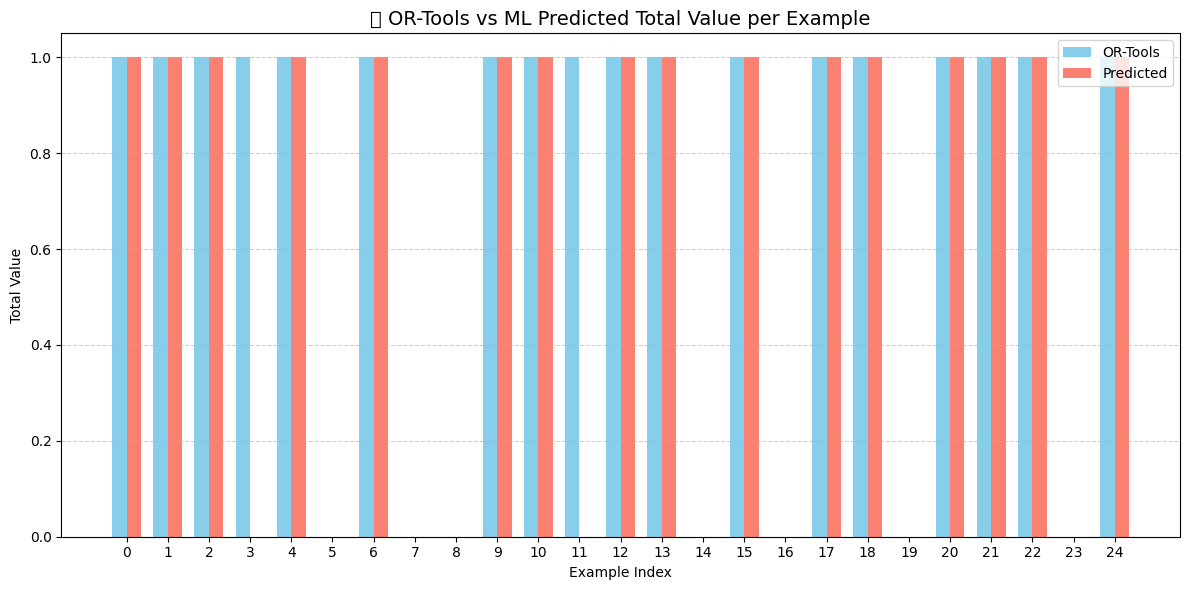

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Select first 20 examples for clarity
N = 25
true_values = df_labeled[:N]['label'].values
predicted_values = example_pred[:N]

# X axis for groups
indices = np.arange(N)
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(indices - width/2, true_values, width=width, label='OR-Tools', color='skyblue')
plt.bar(indices + width/2, predicted_values, width=width, label='Predicted', color='salmon')

plt.title("📊 OR-Tools vs ML Predicted Total Value per Example", fontsize=14)
plt.xlabel("Example Index")
plt.ylabel("Total Value")
plt.xticks(indices)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("knapsack_bar_comparison.png", dpi=300)
plt.show()

<ipython-input-28-bb454aa8d7c2>:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-bb454aa8d7c2>:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("accuracy_per_example_plot.png", dpi=300)


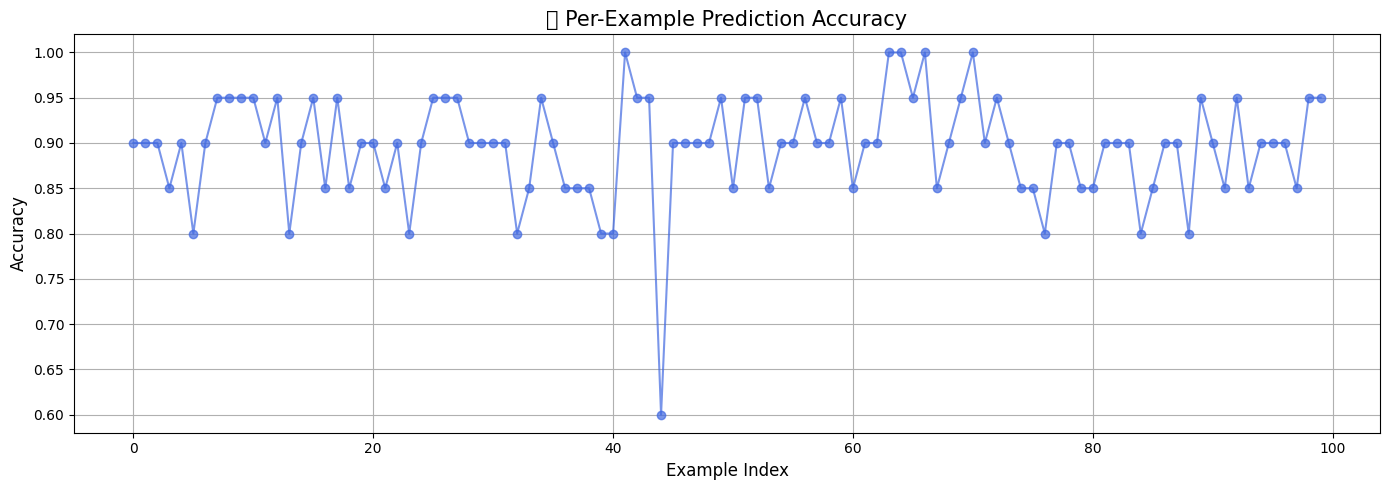

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Flattened arrays of shape (n_items_total,)
true_values = np.array(df_labeled['label'].tolist()).flatten()
predicted_values = np.array(example_pred).flatten()

accuracies = []

# Iterate over each example and compute per-example accuracy
for i in range(100):
    start = i * n_items
    end = start + n_items
    true = true_values[start:end]
    pred = predicted_values[start:end]

    acc = np.mean(true == pred)
    accuracies.append(acc)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(accuracies, marker='o', linestyle='-', color='royalblue', alpha=0.7)
plt.title("📊 Per-Example Prediction Accuracy", fontsize=15)
plt.xlabel("Example Index", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_per_example_plot.png", dpi=300)
plt.show()